# Projet EMA

Ce projet est réalisé dans le cadre du cours Sécurité des composants à l'ENSTA Bretagne.

## Installation

- Télécharger le projet sur [GitHub](https://github.com/lbf38/projet-EMA)
- Télécharger et décompresser les données liées au projet sur [Google Drive](https://drive.google.com/file/d/1AaCzWpeH1CYeZKWcHrNDScyZVNeUsWnc/view?usp=share_link)
- Vérifier bien que les données sont à la racine du dossier `TRACES_DATA` dans le dossier de votre projet. (Par exemple, vous travaillez dans le dossier `projet-EMA`, vous devez avoir le dossier `TRACES_DATA` à la racine de ce dossier)
- Vous pouvez maintenant lancer le notebook `projet_EMA.ipynb`

Les temps d'exécution des cellules sont donnés dans le notebook. Ils correspondent à des temps d'exécution sur un ordinateur portable avec un processeur Intel Core i5-7thGen et 16 Go de RAM.

Source des données : [Archive des données sur Google Drive](https://drive.google.com/file/d/1AaCzWpeH1CYeZKWcHrNDScyZVNeUsWnc/view?usp=share_link) \
Sujet : [Sujet du projet](./projet_2022.pdf)

In [14]:
import matplotlib.pyplot as plt
import os
import re
import scipy.io as sio
import numpy as np
# import modin.pandas as pd
import pandas as pd

os.environ['MODIN_ENGINE'] = 'ray'  # Modin will use Ray
directory = os.path.join(os.getcwd(), 'TRACES_DATA')
tracesFiles = os.listdir(directory)

## Etape 1 : Récupération des données brutes
On veut des matrices de la forme :

- keys : 20 000 lignes, 16 colonnes
- pti : 20 000 lignes, 16 colonnes
- cto : 20 000 lignes, 16 colonnes
- traces : 20 000 lignes, 4 000 colonnes


Ensuite, on les enregistre dans leur fichier respectif sous forme de matrices.

### Récupération des informations dans le nom des fichiers
On récupère les informations dans le nom des fichiers et on les stocke dans des matrices (`numpy`).
Les fichiers sont de la forme : `trace_AES_0000001_key=4c8cdf23b5c906f79057ec7184193a67_pti=8b5061cad6ae6aa4369eac99585d2bcb_cto=554b407d3634156c081abe31752ebd02.csv`

**Temps d'exécution : 1.9s**

In [16]:
keys = np.empty((len(tracesFiles), 16))
pti = np.empty((len(tracesFiles), 16))
cto = np.empty((len(tracesFiles), 16))
regex_filename = re.compile(
    r'\w*key=([a-z0-9]+)_pti=([a-z0-9]+)_cto=([a-z0-9]+).csv')
for i,filename in enumerate(tracesFiles):
    matchfilename = regex_filename.match(filename)
    if (matchfilename):
        keys_string = matchfilename.group(1)
        pti_string = matchfilename.group(2)
        cto_string = matchfilename.group(3)
        keys[i,:] = [int(keys_string[i:i+2], 16) for i in range(0, len(keys_string), 2)]
        pti[i,:] = [int(pti_string[i:i+2], 16) for i in range(0, len(pti_string), 2)]
        cto[i,:] = [int(cto_string[i:i+2], 16) for i in range(0, len(cto_string), 2)]
print(keys.shape, pti.shape, cto.shape)
print(keys[:5,:])


(20000, 16) (20000, 16) (20000, 16)
[[ 76. 140. 223.  35. 181. 201.   6. 247. 144.  87. 236. 113. 132.  25.
   58. 103.]
 [ 76. 140. 223.  35. 181. 201.   6. 247. 144.  87. 236. 113. 132.  25.
   58. 103.]
 [ 76. 140. 223.  35. 181. 201.   6. 247. 144.  87. 236. 113. 132.  25.
   58. 103.]
 [ 76. 140. 223.  35. 181. 201.   6. 247. 144.  87. 236. 113. 132.  25.
   58. 103.]
 [ 76. 140. 223.  35. 181. 201.   6. 247. 144.  87. 236. 113. 132.  25.
   58. 103.]]


### Récupération des traces
On récupère les traces dans les fichiers et on les stocke dans une matrice (`numpy`).
Elle doit être de taille : 
- traces : 20 000 lignes, 4 000 colonnes

**Temps d'exécution : 12s pour 1000 valeurs** \
**Temps estimé pour 20 000 valeurs : 4min** \
**Temps d'exécution : 4min 55s**

In [31]:
traces = np.empty((len(tracesFiles), 4000))

for i, filename in enumerate(tracesFiles):
    fullPath = os.path.join(directory, filename)
    traces[i,:] = np.fromfile(fullPath, dtype=float, sep=',')

print(traces.shape)
print(traces[:-5])
print(traces[:5])

(20000, 4000)
[[ 0.0032526   0.003226    0.003206   ...  0.0029863   0.0030928
   0.0032093 ]
 [ 0.0021939   0.0021973   0.0022039  ...  0.0027399   0.0027066
   0.0026634 ]
 [ 0.0022672   0.0022971   0.0023238  ...  0.00037953  0.00025302
   0.00012984]
 ...
 [ 0.0011652   0.0011086   0.001052   ...  0.006432    0.0063987
   0.0063354 ]
 [ 0.0024536   0.0022605   0.0020508  ... -0.0040716  -0.0040649
  -0.0040416 ]
 [ 0.0016013   0.0015581   0.0015115  ...  0.0046642   0.0045577
   0.0044345 ]]
[[ 0.0032526   0.003226    0.003206   ...  0.0029863   0.0030928
   0.0032093 ]
 [ 0.0021939   0.0021973   0.0022039  ...  0.0027399   0.0027066
   0.0026634 ]
 [ 0.0022672   0.0022971   0.0023238  ...  0.00037953  0.00025302
   0.00012984]
 [-0.00082231 -0.00072243 -0.0006159  ...  0.00096879  0.00092551
   0.00087225]
 [-0.0016313  -0.0015914  -0.0015348  ... -0.00028631 -0.0003762
  -0.00046276]]


## Enregistrement des données au format `.mat`
On enregistre les données au format `.mat` pour pouvoir les utiliser avec `scipy.io.loadmat` ou dans matlab.

**Temps d'exécution: 7s**

In [33]:
converted_directory = os.path.join(os.getcwd(), 'TRACES_DATA_CONVERTED')
if(not os.path.exists(converted_directory)):
    os.mkdir(converted_directory)
sio.savemat(os.path.join(converted_directory,'traces.mat'), {'traces': traces})
sio.savemat(os.path.join(converted_directory,'keys.mat'), {'keys': keys})
sio.savemat(os.path.join(converted_directory,'pti.mat'), {'pti': pti})
sio.savemat(os.path.join(converted_directory,'cto.mat'), {'cto': cto})

# Affichage de la moyenne des traces
On affiche la moyenne des traces sur toutes les valeurs de la clé.
On constate que l'on a 12 pics, ce qui correspond aux 12 rounds de l'algorithme AES étudié.

On voit également que le dernier round a lieu entre 3000 et 3300.
Pour le moment, on affiche simplement les courbes afin de voir la forme que l'on obtient.
On affinera le traitement et l'affichage par la suite.

### Détermination de la plage du chiffrement
A partir du graphique ci-dessus, on peut déterminer la plage du chiffrement. \
Ainsi, on voit une série de piques qui témoignent des rounds de chiffrement. \
La plage du chiffrement est comprise entre 800 et 3000.

**Temps d'exécution : 3min25s**

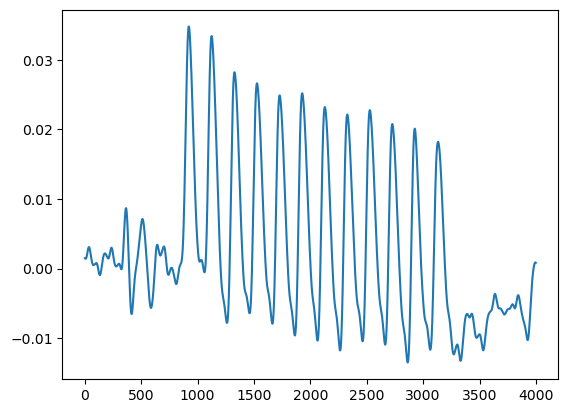

In [38]:
traces_mean = np.mean(traces, axis=0)
plt.plot(traces_mean)
plt.show()